# Kaggle: House Prices

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Extended Linear regression

* Log-transform dependent variable
* L2-L1 regression via Elastic net

In [1]:
import warnings
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
import preprocess

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_train = preprocess.preprocess(df_train)

features = list(df_train.columns)
features.remove('SalePrice')
features.remove('Id')

df_test = pd.read_csv('./data/test.csv')
df_test = preprocess.preprocess(df_test, columns_needed=features)

Columns {'RoofMatl_ClyTile', 'RoofMatl_Membran', 'ExteriorOther', 'RoofMatl_Metal', 'Electrical_Mix', 'HouseStyle_2.5Fin', 'RoofMatl_Roll', 'MiscFeature_TenC', 'Heating_OthW', 'Heating_Floor'} are missing, adding them.


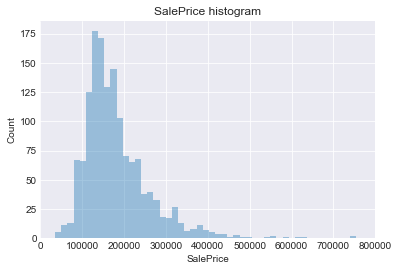

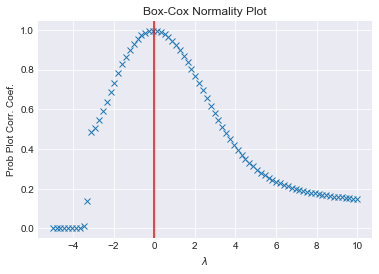

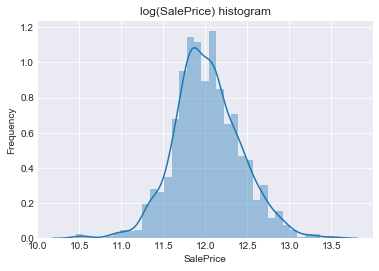

In [4]:
# Check transform of dependent variable
from scipy import stats

# Plot the untransformed histogram
sns.distplot(df_train['SalePrice'], hist=True, kde=False, norm_hist=False)
plt.title('SalePrice histogram')
plt.ylabel('Count')
plt.xlim([0, 800000])
plt.show()

# Plot box-cox transform for multiple values of lmbda
fig = plt.figure()
ax = fig.add_subplot(111)
stats.boxcox_normplot(df_train['SalePrice'], -5, 10, plot=ax)
ax.axvline(0, color='r')
plt.show()

# lmbda is around 0 so assume a log transform
# Log-transform also means that our price will be strictly positive (as house prices do)
y_train = df_train['SalePrice']
y_train_t = np.log(y_train)

sns.distplot(y_train_t)
plt.title('log(SalePrice) histogram')
plt.ylabel('Frequency')
plt.show()

In [5]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

y_train = np.log(df_train['SalePrice']).values.reshape(-1, 1)
print('y_train: ', y_train.shape)

x_train = df_train[features].values
print('x_train: ', x_train.shape)

# Build regressor that first scales the data and then trains a regularised linear regressor
# StandardScaler standardizes features by removing the mean and scaling to unit variance
# ElasticNetCV: Elastic Net model with iterative fitting along a regularization path. The best model is selected by cross-validation.
regressor = ElasticNetCV(
    l1_ratio=[0.0, 0.01, 0.03, 0.05, .1, 0.2, .5, .7, .9, .95, .99, 1], 
    alphas=[0.01, 0.1, 0.2, 0.5, 1.],
    tol=0.0001, cv=11, selection='cyclic')
model = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', regressor)])
model.fit(x_train, y_train)

print('Regression alpha: ', model.named_steps['linear'].alpha_)
print('Regression l1_ratio: ', model.named_steps['linear'].l1_ratio_)

y_train:  (1460, 1)
x_train:  (1460, 250)
Regression alpha:  0.1
Regression l1_ratio:  0.03


y_train_pred:  (1460,)
Mean squared error: 542654195.280989
Variance score: 0.9139571292207928


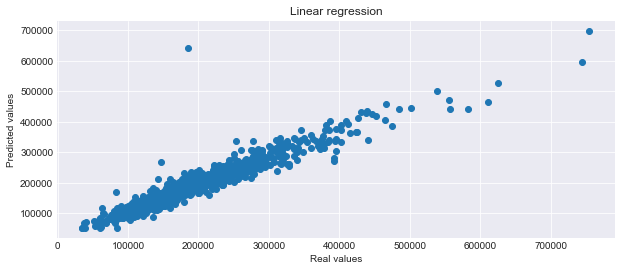

In [6]:
# Predictions from train set
from sklearn.metrics import mean_squared_error, r2_score

y_train_pred = np.exp(model.predict(x_train))
print('y_train_pred: ', y_train_pred.shape)

print('Mean squared error: {}'.format(mean_squared_error(df_train['SalePrice'], y_train_pred)))
print('Variance score: {}'.format(r2_score(df_train['SalePrice'], y_train_pred)))


# Plot predictions
plt.figure(figsize=(10, 4))
plt.scatter(df_train['SalePrice'], y_train_pred)
plt.title('Linear regression')
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.show()

x_test:  (1459, 250)
y_test_pred:  (1459,)
1 values above 800k


,Id,SalePrice
0,1461,122071.741238
...,...,...
1458,2919,224435.941396


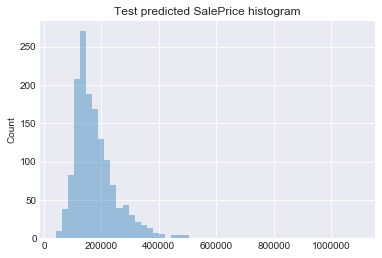

In [7]:
# Make predictions on test set and save the results
# This gets an error of 0.12767 on the leaderboard. 
x_test = df_test[features].values
print('x_test: ', x_test.shape)

y_test_pred = np.exp(model.predict(x_test))
print('y_test_pred: ', y_test_pred.shape)

# Test for negative and infinity values:
assert (y_test_pred >= 0).all()
assert not np.isinf(y_test_pred).any(), '{} infinity values '.format(sum(np.isinf(y_test_pred)))
print('{} values above 800k'.format(sum(y_test_pred >= 800000)))

df_test_predict = df_test[['Id']]
df_test_predict['SalePrice'] = np.squeeze(y_test_pred)
assert df_test_predict.notnull().all().all()

with pd.option_context('display.max_rows', 3, 'display.max_columns', 2):
    display(df_test_predict)
    
df_test_predict.to_csv('output_extd_linear.csv', index=False)

sns.distplot(np.squeeze(y_test_pred), hist=True, kde=False, norm_hist=False)
plt.title('Test predicted SalePrice histogram')
plt.ylabel('Count')
plt.show()